This is SAM2 used for the POC for the Nutritionist

In [2]:
# -----------------Installing the dependencies-----------------

In [3]:
using_colab = True

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-zar6nk71
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-zar6nk71
  Resolved https://github.com/facebookresearch/sam2.git to commit c98aa6bea377d5c000cdc80197ce402dbf5304dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp

In [5]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# -----------select the device for computation-------------
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [7]:
# which visualizes annotations on a 2D image-like mask

np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

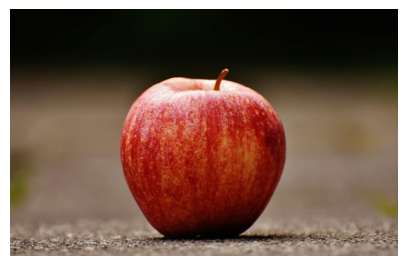

In [9]:
# -------------Selecting and Resizing the Image-----------------


def resize_image(image_path, width=512):
    # Load the image
    image = Image.open(image_path)

    # Calculate the new height to maintain aspect ratio
    aspect_ratio = width / image.width
    new_height = int(image.height * aspect_ratio)

    # Resize the image
    resized_image = image.resize((width, new_height))

    # Convert to NumPy array for plotting
    image_np = np.array(resized_image.convert("RGB"))

    # Display the resized image
    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

    return image_np


image = resize_image('/content/Apple.jpg')

#Mask generation

In [10]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [11]:
# ------------Computation-----------
import time

start_time = time.time()
masks = mask_generator.generate(image)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 7.182592391967773 seconds


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [12]:
print(f'Total number of the Masks: {len(masks)}')
print(masks[0].keys())

Total number of the Masks: 4
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


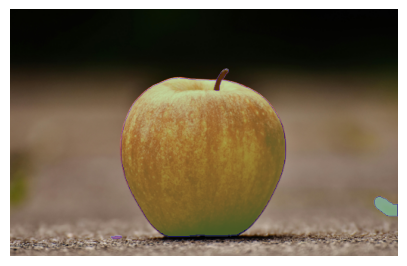

In [13]:
# Overlapping mask on the image

plt.figure(figsize=(5, 5))
plt.imshow(image)
show_anns(masks) # Showing all the masks
plt.axis('off')
plt.show()

mask=>{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 37716, 'bbox': [146.0, 79.0, 217.0, 221.0], 'predicted_iou': 0.99609375, 'point_coords': [[312.0, 106.96875]], 'stability_score': 0.9854729175567627, 'crop_box': [0.0, 0.0, 512.0, 326.0]}


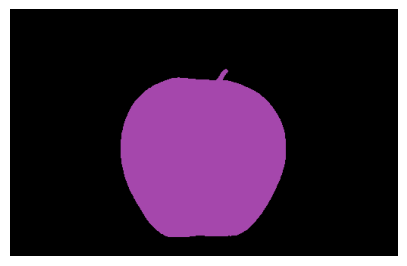

In [14]:
# single segment MASK


# Create a blank canvas of the same size as the original image
blank_canvas = np.zeros_like(image)

# Function to visualize a single mask on a blank canvas
def show_single_ann(mask):
    color = np.random.rand(3)  # Random color for the mask
    blank_canvas[mask['segmentation']] = color * 255  # Color the selected mask region

# Select a single mask (e.g., the first mask in the list)
single_mask = masks[0]  # change the index to visualize a different masks
print(f'mask=>{single_mask}')
# Generate the mask on the blank canvas
show_single_ann(single_mask)

# Display the mask only, without the original image
plt.figure(figsize=(5,5))
plt.imshow(blank_canvas)
plt.axis('off')
plt.show()


#### Extract and Display the Masked Image Portion


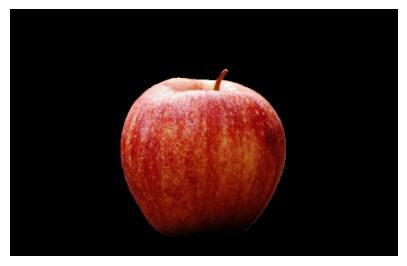

In [18]:
# Function to extract and visualize the masked portion of the image

def extract_masked_region(image, mask):
    # Create a blank canvas (same shape as the original image)
    masked_image = np.zeros_like(image)

    # Apply the mask to extract the region from the original image
    segmentation = mask['segmentation']

    # Copy the pixels from the original image to the masked image
    masked_image[segmentation] = image[segmentation]

    return masked_image

# Example usage
# Assume `single_mask` is the mask you want to visualize
single_mask = masks[0]  # Change index to use other masks if needed

# Extract the portion of the image with the selected mask
masked_region = extract_masked_region(image, single_mask)

# Display the extracted region
plt.figure(figsize=(5, 5))
plt.imshow(masked_region)
plt.axis('off')
plt.show()


In [15]:
# Checking if the point is inside the Segment or not.

x = 313
# y=300.  Point outside the segment
y = 107

is_segment=single_mask['segmentation']
if is_segment[y, x]:
    print("The point is inside the segment.")
else:
    print("The point is outside the segment.")

The point is inside the segment.


#### Returning the Mask with cordinates values

In [16]:
def get_mask_at_coordinates(masks, x, y):
    """
    Given a list of masks and coordinates (x, y),
    return the mask that contains the point (x, y).
    """
    for mask in masks:
        # Each mask contains a 'segmentation' key, which is a 2D NumPy array
        is_segment = mask['segmentation']

        # Check if the point (x, y) is inside the current mask
        if is_segment[y, x]:
            return mask  # Return the matching mask

    return None  # If no mask contains the point (x, y)

# Example usage
# Assume `masks` is a list of masks generated by SAM2AutomaticMaskGenerator
x = 313
y = 107



# Get the mask at the given coordinates
mask = get_mask_at_coordinates(masks, x, y)

if mask:
    print("Found a mask at the given coordinates.")
    print("Mask info:", mask)
else:
    print("No mask found at the given coordinates.")


Found a mask at the given coordinates.
Mask info: {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 37716, 'bbox': [146.0, 79.0, 217.0, 221.0], 'predicted_iou': 0.99609375, 'point_coords': [[312.0, 106.96875]], 'stability_score': 0.9854729175567627, 'crop_box': [0.0, 0.0, 512.0, 326.0]}


In [17]:
print(masks)
# conclusion it is working fine.

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 37716, 'bbox': [146.0, 79.0, 217.0, 221.0], 'predicted_iou': 0.99609375, 'point_coords': [[312.0, 106.96875]], 'stability_score': 0.9854729175567627, 'crop_box': [0.0, 0.0, 512.0, 326.0]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 230, 'bbox': [269.0, 78.0, 19.0, 29.0], 'predicted_iou': 0.9

### Model Customizeable Parameters.



In [ ]:
# Params Documentation (Geaky Ants ID Access Only) ->
'https://docs.google.com/document/d/12E_jec6761ihQjxu1cBTy1cMig87x0pps6zMfEhcjgY/edit'

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=4,  # Points per Side for computation
    points_per_batch=16,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

masks2 = mask_generator_2.generate(image)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()